## Background

This script is for estimating an updated WFH model for TM1.6.1. The [initial WFH model created for TM1.6.0](https://github.com/BayAreaMetro/travel-model-one/pull/63) was estimated using ACS 2021 data (and later updated to use ACS 2022 data) based on household income, home county, and industry. However, ACS and ACS PUMS data on WFH has the limitation that for workers who report WFH as their primary journey-to-work mode for the reference week, no distinct workplace (from home) is reported.

MTC staff looked at data from the [2023 Bay Area Travel Study (BATS)](https://mtc.ca.gov/tools-resources/survey-program) where workplace location was reported for all respondents who had a workplace, even if they worked from home on a survey day. We [found that the distances between work and home tended to be longer for people who worked from home](https://10ay.online.tableau.com/t/metropolitantransportationcommission/views/BATS-2023-SurveyDataViz--WeightedDataset_09112024_17261683633090/Dist-to-WorkTable), which is intuitve because a longer commute would incentive workers to WFH. However, the ACS-based WFH model implemented resulted in the reverse pattern.

Therefore, the goal here is to estimate a simple model using BATS 2023 data and a similar set of independent variables (to minimize implementation effort due to limited time available), but with the addition of a distance-to-work term included.

Asana task (internal): [Estimate WFH binomial logit model using BATS2023](https://app.asana.com/0/15119358130897/1208621825395379/f)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import pathlib

pd.options.display.max_rows = 1000

WORKSPACE_DIR = pathlib.Path("M:\\Development\\Travel Model One\\Estimation\\WFH_BATS_2023")

## 1. Prepare BATS 2023 data

In [2]:
# default is C:/Users/username/Box
BOX_ROOT_DIR = pathlib.Path("C:/Users") / os.environ['USERNAME'] / "Box"
if (os.environ['USERNAME'] == 'lzorn'):
    BOX_ROOT_DIR = pathlib.Path("E:/Box")

BATS_DATA_DIR = BOX_ROOT_DIR / "Modeling and Surveys" / "Surveys" / "Travel Diary Survey" / "Biennial Travel Diary Survey" / \
    "MTC_RSG_Partner Repository" / "5.Deliverables" / "Task 10 - Final Weighted and Expanded Data Files" / "WeightedDataset_09112024"

### 1.1 Read households data for household income, home location

In [3]:
# read households
bats_hhlds = pd.read_csv(BATS_DATA_DIR / "hh.csv")
print(f"Read {len(bats_hhlds):,} rows from \"{BATS_DATA_DIR / 'hh.csv'}")

# print("\nbats_hhlds.dtypes:")
# print(bats_hhlds.dtypes)

# select relevant variables
bats_hhlds = bats_hhlds[[
    'hh_id',
    'home_lon','home_lat','home_in_region','home_county',
    'income_detailed','income_followup','income_broad','income_imputed']]

# filter to home_in_region? Not necesary -- these are all 1
print("\nAll records have home_in_region==1:")
print(bats_hhlds['home_in_region'].value_counts(dropna=False))

COUNTY_RECODE = {
    6001: 'Alameda',
    6013: 'ContraCosta',
    6041: 'Marin',
    6055: 'Napa',
    6075: 'SanFrancisco',
    6081: 'SanMateo',
    6085: 'SantaClara',
    6095: 'Solano',
    6097: 'Sonoma'
}
bats_hhlds['home_county_str'] = bats_hhlds.home_county.map(COUNTY_RECODE)
# add dummies for income_imputed
homecounty_dummies = pd.get_dummies(data=bats_hhlds.home_county_str, prefix="home")
# combine Marin, Napa and Sonoma
homecounty_dummies['home_MarinNapaSonoma'] = homecounty_dummies.home_Marin + homecounty_dummies.home_Napa + homecounty_dummies.home_Sonoma
# combine Solano, Marin, Napa and Sonoma
homecounty_dummies['home_NorthBay'] = homecounty_dummies.home_Solano + homecounty_dummies.home_Marin + homecounty_dummies.home_Napa + homecounty_dummies.home_Sonoma

homecounty_dummies.drop(columns=['home_Marin','home_Napa','home_Sonoma'], inplace=True)
bats_hhlds = bats_hhlds.join(homecounty_dummies)

Read 8,258 rows from "E:\Box\Modeling and Surveys\Surveys\Travel Diary Survey\Biennial Travel Diary Survey\MTC_RSG_Partner Repository\5.Deliverables\Task 10 - Final Weighted and Expanded Data Files\WeightedDataset_09112024\hh.csv

All records have home_in_region==1:
home_in_region
1    8258
Name: count, dtype: int64


#### 1.1.1 Recode household income

In [4]:
# recode
INCOME_IMPUTED_RECODE = {
    'Under $25,000'    : '000to025k',
    '$25,000-$49,999'  : '025to050k',
    '$50,000-$74,999'  : '050to075k',
    '$75,000-$99,999'  : '075to100k',
    '$100,000-$199,999': '100to200k',
    '$200,000 or more' : '200plusk'
}
bats_hhlds['income_imputed'] = bats_hhlds.income_imputed.map(INCOME_IMPUTED_RECODE)

# use income_imputed?
print("\nIncome variable tabulation:")
print(bats_hhlds[['income_detailed','income_imputed']].value_counts(dropna=False))

# add dummies for income_imputed
hhinc_dummies = pd.get_dummies(data=bats_hhlds.income_imputed, prefix="hhinc")
bats_hhlds = bats_hhlds.join(hhinc_dummies)

# recode to value
# TODO: this is crude, but I don't know that sampling a number in this range would be preferable?
# These are the weighted averages of household income from PUMS 2023, filtered to employed persons only
# via census-tools-for-planning\Analysis\investigateWorkFromHomeMergedPUMS.R
# See https://10ay.online.tableau.com/t/metropolitantransportationcommission/views/WFH_BATS_2023/2023PUMSIncome
INCOME_IMPUTED_NOMINAL_RECODE = {
    '000to025k' : 11775.0,
    '025to050k':  35561.0,
    '050to075k':  62278.0,
    '075to100k':  86847.0,
    '100to200k': 144350.0,
    '200plusk' : 318930.0,
}
bats_hhlds['income_imputed_nominal'] = bats_hhlds.income_imputed.map(INCOME_IMPUTED_NOMINAL_RECODE)
# convert from 2023 dollars to 2000 dollars
# https://github.com/BayAreaMetro/modeling-website/wiki/InflationAssumptions
DOLLARS_2000_TO_2023 = 1.88
bats_hhlds['income_imputed_nominal_2000d'] = bats_hhlds.income_imputed_nominal / DOLLARS_2000_TO_2023
bats_hhlds['ln_income_imputed_nominal_2000d'] = np.log(bats_hhlds.income_imputed_nominal_2000d)


Income variable tabulation:
income_detailed  income_imputed
7                100to200k         1370
10               200plusk          1235
8                100to200k          935
6                075to100k          852
5                050to075k          761
9                200plusk           622
999              100to200k          547
1                000to025k          428
4                025to050k          417
2                000to025k          305
3                025to050k          303
999              200plusk           261
                 000to025k          122
                 025to050k           45
                 050to075k           29
                 075to100k           26
Name: count, dtype: int64


### 1.2 Read person data for employment status, work location and industry

Filter to employed persons who have a recorded work location in the region.

In [5]:
# read persons
bats_persons = pd.read_csv(BATS_DATA_DIR / "person.csv")
print(f"Read {len(bats_persons):,} rows from \"{BATS_DATA_DIR / 'person.csv'}\"")

# print("\nbats_persons.dtypes:")
# print(bats_persons.dtypes)

# select relevant variables
bats_persons = bats_persons[[
    'hh_id','person_id',
    'employment','work_lat','work_lon','work_in_region','work_county',
    'industry','industry_other',
    'can_telework']]

print("\nFiltering to: employment == 1 Employed full-time (paid) or 2 Employed part-time (paid)")
bats_persons = bats_persons.loc[bats_persons.employment.isin([1,2])]
print(f" => {len(bats_persons):,} rows")

# set variable for has_work_location
bats_persons['has_work_location'] = False
bats_persons.loc[pd.notna(bats_persons.work_lat) & pd.notna(bats_persons.work_lon), "has_work_location"] = True

print("\nWork in region vs has_work_location tabulation:")
print(bats_persons[["work_in_region","has_work_location"]].value_counts(dropna=False))

# It looks like work_in_region==995 => has_work_location==False
# Drop work_in_region==0 and has_work_location==False
print("\nFiltering to: work_in_region==1 and has_work_location==True")
bats_persons = bats_persons.loc[(bats_persons.work_in_region == 1)&
                                (bats_persons.has_work_location==True)]
print(f" => {len(bats_persons):,} rows")



Read 15,985 rows from "E:\Box\Modeling and Surveys\Surveys\Travel Diary Survey\Biennial Travel Diary Survey\MTC_RSG_Partner Repository\5.Deliverables\Task 10 - Final Weighted and Expanded Data Files\WeightedDataset_09112024\person.csv"

Filtering to: employment == 1 Employed full-time (paid) or 2 Employed part-time (paid)
 => 8,374 rows

Work in region vs has_work_location tabulation:
work_in_region  has_work_location
1               True                 5982
995             False                2328
0               True                   64
Name: count, dtype: int64

Filtering to: work_in_region==1 and has_work_location==True
 => 5,982 rows


#### 1.2.1 Recode industry to TM1 categories

See https://github.com/BayAreaMetro/modeling-website/wiki/TazData

* `RETEMPN`: Retail trade employment (NAICS-based)
* `FPSEMPN`: Financial and professional services employment (NAICS-based)
* `HEREMPN`: Health, educational and recreational service employment (NAICS-based)
* `AGREMPN`: Agricultural and natural resources employment (NAICS-based)
* `MWTEMPN`: Manufacturing, wholesale trade and transportation employment (NAICS-based)
* `OTHEMPN`: Other employment (NAICS-based)

Also see [NAICS_to_EMPSIX.xlsx](https://github.com/BayAreaMetro/travel-model-one/blob/master/utilities/taz-data-baseyears/2015/Employment/NAICS_to_EMPSIX.xlsx)


In [6]:
INDUSTRY_RECODE = {
    1   : 'AGREMPN', # Agriculture, Forestry, Fishing, and Hunting
    2   : 'AGREMPN', # Mining, Quarrying, and Oil and Gas Extraction
    3   : 'MWTEMPN', # Utilities
    4   : 'OTHEMPN', # Construction
    5   : 'MWTEMPN', # Manufacturing
    6   : 'MWTEMPN', # Wholesale Trade
    7   : 'RETEMPN', # Retail Trade
    8   : 'MWTEMPN', # Transportation and Warehousing
    9   : 'OTHEMPN', # Information
    10  : 'FPSEMPN', # Finance and Insurance
    11  : 'FPSEMPN', # Real Estate and Rental and Leasing
    12  : 'FPSEMPN', # Professional, Scientific, and Technical Services
    13  : 'FPSEMPN', # Management of Companies and Enteprises
    14  : 'FPSEMPN', # Administrative and Support and Waste Management and Remediation Services
    15  : 'HEREMPN', # Educational Servies
    16  : 'HEREMPN', # Helath Care and Social Assitance
    17  : 'HEREMPN', # Arts, Entertainment, and Recreation
    18  : 'HEREMPN', # Accommodation and Food Services
    19  : 'OTHEMPN', # Other Services (except Public Administration)
    20  : 'OTHEMPN', # Public Administration
    # 995 : NA,   # Missing Response
    # 997 : NA,   # Other, please specify
}

bats_persons['empsix'] = bats_persons.industry.map(INDUSTRY_RECODE)
print("After recoding 'industry':")
print(bats_persons['empsix'].value_counts(dropna=False))

# try to resolve some of the remaining
bats_persons.industry_other = bats_persons.industry_other.str.lower()
bats_persons.industry_other = bats_persons.industry_other.str.strip()

INDUSTRY_OTHER_TERM_RECODE = {
    'technology'             : 'FPSEMPN',
    'biotechnology'          : 'FPSEMPN',
    'biotech'                : 'FPSEMPN',
    'biomedical'             : 'FPSEMPN',
    'tech'                   : 'FPSEMPN',
    'software'               : 'FPSEMPN',
    'security'               : 'FPSEMPN', # NAICS 561612
    'government'             : 'OTHEMPN',
    'judicial'               : 'OTHEMPN',
    'national park service'  : 'OTHEMPN',
    'law enforcement'        : 'OTHEMPN',
    'military'               : 'OTHEMPN',
    'library'                : 'OTHEMPN',
    'automotive'             : 'MWTEMPN',
    'nonprofit'              : 'HEREMPN',
    'non-profit'             : 'HEREMPN',
    'non profit'             : 'HEREMPN',
    'philanthropy'           : 'HEREMPN',
    'childcare'              : 'HEREMPN',
    'health'                 : 'HEREMPN',
    'fitness'                : 'HEREMPN',
    'school'                 : 'HEREMPN',
    'legal'                  : 'FPSEMPN',
    'law'                    : 'FPSEMPN',
    'attorney'               : 'FPSEMPN',
    'marketing'              : 'FPSEMPN',
    'hospitality'            : 'HEREMPN',
    'hotel'                  : 'HEREMPN',
    'e-commerce'             : 'RETEMPN',
    'ecommerce'              : 'RETEMPN',
}
# if any of these words appear, apply it
for term in INDUSTRY_OTHER_TERM_RECODE.keys():
    bats_persons.loc[pd.isna(bats_persons.empsix) & 
                     (bats_persons.industry_other.str.find(term) >=0), 'empsix'] = INDUSTRY_OTHER_TERM_RECODE[term]

# print("\nindustry_other for NA empsix:")
# print(bats_persons.loc[pd.isna(bats_persons.empsix),'industry_other'].value_counts(dropna=False))

print("\nAfter recoding 'industry_other':")
print(bats_persons['empsix'].value_counts(dropna=False))

print("\nFiltering out NaN industry:")
bats_persons = bats_persons.loc[pd.notna(bats_persons.empsix)]
print(f" => {len(bats_persons):,} rows")

# add dummies for empsix
ind_dummies = pd.get_dummies(data=bats_persons.empsix, prefix="ind")
bats_persons = bats_persons.join(ind_dummies)

After recoding 'industry':
empsix
HEREMPN    1886
FPSEMPN    1379
OTHEMPN    1107
NaN         754
MWTEMPN     604
RETEMPN     211
AGREMPN      41
Name: count, dtype: int64

After recoding 'industry_other':
empsix
HEREMPN    1987
FPSEMPN    1588
OTHEMPN    1174
MWTEMPN     619
NaN         358
RETEMPN     215
AGREMPN      41
Name: count, dtype: int64

Filtering out NaN industry:
 => 5,624 rows


### 1.3 Merge persons with households

In [7]:
# Merge with households
bats_persons = pd.merge(
    left=bats_persons,
    right=bats_hhlds,
    on=['hh_id'],
    how='left',
    validate='many_to_one',
    indicator=True
)
# verify all person records have household information
assert all(bats_persons['_merge'] == 'both'), "Not all values in _merge are 'both'"
bats_persons.drop(columns=['_merge'],inplace=True)
# bats_persons.head()

### 1.4 Filter out persons where work location == home location

In [8]:
# If work location == home location, they don't have a work location outside of the home
# This isn't a modeled use case, so filter out
bats_persons['work_loc_is_home_loc'] = False
bats_persons.loc[(bats_persons.work_lon == bats_persons.home_lon) &
                 (bats_persons.work_lat == bats_persons.home_lat),
                 'work_loc_is_home_loc'] = True
print(f"bats_persons['work_loc_is_home_loc'].value_counts()=\n{bats_persons['work_loc_is_home_loc'].value_counts()}")

print("\nFiltering to: work_loc_is_home_loc==False")
bats_persons = bats_persons.loc[bats_persons.work_loc_is_home_loc==False]
print(f" => {len(bats_persons):,} rows")


bats_persons['work_loc_is_home_loc'].value_counts()=
work_loc_is_home_loc
False    5433
True      191
Name: count, dtype: int64

Filtering to: work_loc_is_home_loc==False
 => 5,433 rows


#### 1.4.1 Attach TM1 TAZ for home location and work location

In [9]:
TM1_SHAPEFILE = pathlib.Path("M:\\Data\\GIS layers\\TM1_taz\\bayarea_rtaz1454_rev1_WGS84.shp")
taz_shape_gdf = gpd.read_file(TM1_SHAPEFILE)
print(f"Read {len(taz_shape_gdf):,} rows from '{TM1_SHAPEFILE}'")
print(taz_shape_gdf.crs)

# spatial join home and work locations with TAZ
nrows = len(bats_persons)
for loc in ['home','work']:
    loc_geometry = [shapely.geometry.Point(xy) for xy in zip(bats_persons[f'{loc}_lon'],bats_persons[f'{loc}_lat'])]
    bats_persons_gdf = gpd.GeoDataFrame(
        data=bats_persons[['hh_id','person_id']], 
        geometry=loc_geometry,
        crs='EPSG:4326')

    assert(nrows == len(bats_persons_gdf))
    bats_persons_gdf = gpd.sjoin_nearest(
        bats_persons_gdf, 
        taz_shape_gdf, 
        how='left')
    assert(nrows == len(bats_persons_gdf))

    print(f"Of {len(bats_persons_gdf):,} rows, {len(bats_persons_gdf.loc[pd.isna(bats_persons_gdf.TAZ1454)]):,}" + \
      f" failed the TAZ spatial join for {loc}")

    # add back to bats_persons
    bats_persons_gdf.rename(columns={'TAZ1454':f'{loc}_TAZ1454'}, inplace=True)
    bats_persons = pd.merge(
        left=bats_persons,
        right=bats_persons_gdf[['hh_id','person_id',f'{loc}_TAZ1454']],
        how='left',
        on=['hh_id','person_id']
    )

# note: I visually checked that this looks reasonable

Read 1,454 rows from 'M:\Data\GIS layers\TM1_taz\bayarea_rtaz1454_rev1_WGS84.shp'
EPSG:4326


c:\Users\lzorn\.conda\envs\NetworkWrangler\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Of 5,433 rows, 0 failed the TAZ spatial join for home


c:\Users\lzorn\.conda\envs\NetworkWrangler\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Of 5,433 rows, 0 failed the TAZ spatial join for work


#### 1.4.2 Attach home-to-work distance based on TAZs

`NONMOTSKM_DIST.csv` is an export of the distance skims generated by [NonMotorizedSkims.job](https://github.com/BayAreaMetro/travel-model-one/blob/master/model-files/scripts/skims/NonMotorizedSkims.job) for the model run `2023_TM161_IPA_07`, but this skim does not include any link restrictions so it should be shortest-link-path.

In [10]:
DIST_SKIM_FILE = WORKSPACE_DIR / "NONMOTSKM_DIST.csv"
dist_skim_df = pd.read_csv(DIST_SKIM_FILE, header=None, names=["home_TAZ1454","work_TAZ1454","ones","distance_home_to_work"])
print(f"Read {len(dist_skim_df):,} rows from '{DIST_SKIM_FILE}'")
dist_skim_df.drop(columns=["ones"], inplace=True)

dist_skim_df.head()

# join to bats_persons for home-to-work distance
bats_persons = pd.merge(
    left=bats_persons,
    right=dist_skim_df,
    how='left',
    on=['home_TAZ1454','work_TAZ1454'],
    indicator=True,
    validate='many_to_one'
)
# verify all person records have household information
assert all(bats_persons['_merge'] == 'both'), "Not all values in _merge are 'both'"
bats_persons.drop(columns=['_merge'],inplace=True)

# add ln_distance_home_to_work
bats_persons['ln_distance_home_to_work'] = np.log(bats_persons.distance_home_to_work)

Read 2,175,625 rows from 'M:\Development\Travel Model One\Estimation\WFH_BATS_2023\NONMOTSKM_DIST.csv'


### 1.5 Read day data and merge with persons/households
Filter to Tuesdays, Wednesdays and Thursday

Read 89,112 rows from "E:\Box\Modeling and Surveys\Surveys\Travel Diary Survey\Biennial Travel Diary Survey\MTC_RSG_Partner Repository\5.Deliverables\Task 10 - Final Weighted and Expanded Data Files\WeightedDataset_09112024\day.csv"

Filtering to: travel_dow is Tuesday, Wednesday or Thursday
 => 39,844 rows

Merging with employed persons with work locations
 => 14,791 rows


Text(0, 0.5, 'Frequency')

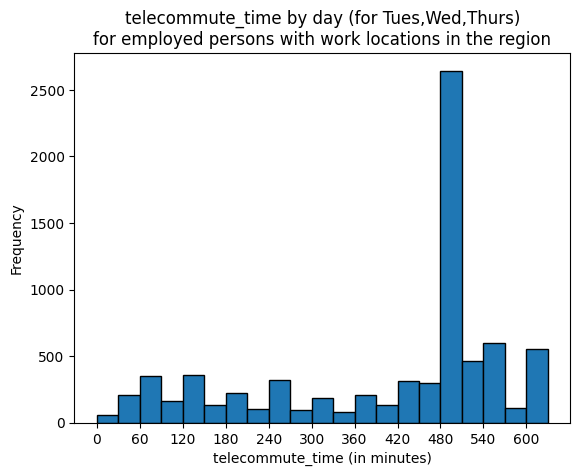

In [11]:
# read day data for day of week and telecommute time spent
bats_day = pd.read_csv(BATS_DATA_DIR / "day.csv")
print(f"Read {len(bats_day):,} rows from \"{BATS_DATA_DIR / 'day.csv'}\"")

# print("\nbats_day.dtypes:")
# print(bats_day.dtypes)

# select relevant variables
bats_day = bats_day[[
    'hh_id','person_id','day_num',
    'travel_date','travel_dow',
    'telecommute_time']]

print("\nFiltering to: travel_dow is Tuesday, Wednesday or Thursday")
bats_day = bats_day.loc[bats_day.travel_dow.isin([2,3,4])]
print(f" => {len(bats_day):,} rows")

# This didn't do anything; holidays were already excluded
# import holidays
# print("\nFiltering to exclude holidays.US()")
# bats_day = bats_day.loc[~bats_day.travel_date.isin(holidays.US())]
# print(f" => {len(bats_day):,} rows")

print("\nMerging with employed persons with work locations")
bats_day = pd.merge(
    left=bats_day,
    right=bats_persons,
    on=['person_id','hh_id'],
    how='right', # keep only days for employed persons with work locations
    validate='many_to_one',
    indicator=True
)
# verify all day records have persons/household information
assert all(bats_day['_merge'] == 'both'), "Not all values in _merge are 'both'"
bats_day.drop(columns=['_merge'],inplace=True)
print(f" => {len(bats_day):,} rows")

# Plot telecommute_time distribution
plt.hist(bats_day.telecommute_time.loc[bats_day.telecommute_time>0], 
         bins=list(range(0,660,30)),
         edgecolor='black')
plt.title('telecommute_time by day (for Tues,Wed,Thurs)\nfor employed persons with work locations in the region')
plt.xlabel('telecommute_time (in minutes)')
plt.xticks(list(range(0,660,60)))
plt.ylabel('Frequency')

### 1.6 Read trips data and filter to complete days
Summarize to the day level and flag if work trip was made

In [12]:
# read day data for day of week and telecommute time spent
bats_trip = pd.read_csv(BATS_DATA_DIR / "trip.csv")
print(f"Read {len(bats_trip):,} rows from \"{BATS_DATA_DIR / 'trip.csv'}\"")

# print("\nbats_trip.dtypes:")
# print(bats_trip.dtypes)

# select relevant variables
bats_trip = bats_trip[[
    'hh_id','person_id','day_num','trip_id',
    'd_purpose_category','day_is_complete']]

# filter to day_is_complete==1
print("\nFiltering to day_is_complete==1")
bats_trip = bats_trip.loc[bats_trip.day_is_complete==1]
print(f" => {len(bats_trip):,} rows")

# create dummy for work trip based on d_purpose_category
bats_trip['made_work_trip'] = 0
bats_trip.loc[bats_trip.d_purpose_category==2, 'made_work_trip'] = 1

# summarize to household/person/day to count work trips and total trips
bats_trip = bats_trip.groupby(by=['hh_id','person_id','day_num']).agg(
    num_trips      = pd.NamedAgg(column='trip_id', aggfunc='count'),
    made_work_trip = pd.NamedAgg(column='made_work_trip', aggfunc='max')
).reset_index(drop=False)

print("\nmade_work_trip tabulation:")
print(bats_trip['made_work_trip'].value_counts())

print("\nbats_trip.dtypes:")
print(bats_trip.dtypes)

Read 365,831 rows from "E:\Box\Modeling and Surveys\Surveys\Travel Diary Survey\Biennial Travel Diary Survey\MTC_RSG_Partner Repository\5.Deliverables\Task 10 - Final Weighted and Expanded Data Files\WeightedDataset_09112024\trip.csv"

Filtering to day_is_complete==1
 => 335,713 rows

made_work_trip tabulation:
made_work_trip
0    51207
1    11884
Name: count, dtype: int64

bats_trip.dtypes:
hh_id             int64
person_id         int64
day_num           int64
num_trips         int64
made_work_trip    int64
dtype: object


### 1.7 Join trips information to day dataset

In [13]:
# Here, we want an inner join because we only want employed persons with work locations
# But we also only want days where the day_is_complete
bats_day = pd.merge(
    left=bats_day,
    right=bats_trip,
    on=['hh_id','person_id','day_num'],
    how='inner',
    validate='one_to_one'
)
print(f"After merging with trips data (which removes days which are not complete), bats_day has {len(bats_day):,} rows")

After merging with trips data (which removes days which are not complete), bats_day has 13,008 rows


### 1.8 Handle days where a person WFH *and* goes to work


Filtering to (telecommute > 0) OR (made_work_trip==1)
 => 10,561 rows


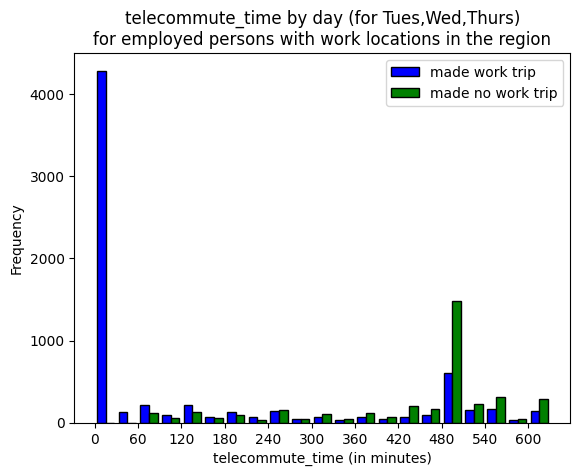


wfh vs goes to work:
wfh  made_work_trip
0    1                 4254
1    0                 3731
     1                 2576
Name: count, dtype: int64

After converting wfh=>0 if made_work_trip==1:
made_work_trip  wfh
1               0      6830
0               1      3731
Name: count, dtype: int64


In [14]:
bats_day.head()
# remove days where the person neither went to work nor telecommuted
# TODO: I'm requiring telecommute_minutes >= 60 to count as working
MIN_WORK_TIME = 60

print("\nFiltering to (telecommute > 0) OR (made_work_trip==1)")
bats_day = bats_day.loc[(bats_day.telecommute_time >= MIN_WORK_TIME)|(bats_day.made_work_trip==1)]
print(f" => {len(bats_day):,} rows")

# Plot telecommute_time distribution by made_work_trip
plt.hist([bats_day.loc[bats_day.made_work_trip==1]['telecommute_time'], 
          bats_day.loc[bats_day.made_work_trip==0]['telecommute_time']],
         bins=list(range(0,660,30)),
         color=['blue','green'],
         label=['made work trip','made no work trip'],
         edgecolor='black')
plt.title('telecommute_time by day (for Tues,Wed,Thurs)\nfor employed persons with work locations in the region')
plt.xlabel('telecommute_time (in minutes)')
plt.xticks(list(range(0,660,60)))
plt.ylabel('Frequency')
plt.legend()
plt.show()

bats_day['wfh'] = 0
bats_day.loc[bats_day.telecommute_time > 0, 'wfh'] = 1
print(f"\nwfh vs goes to work:\n{bats_day[['wfh','made_work_trip']].value_counts(dropna=False)}")


#######################

# The travel model doesn't currently really represent people who make work trips *and* WFH within the same day
# Hence the forumlation of this as binary choice model.
# two options: 
#  1) if they go to work, then they didn't WFH (even if they did both)
#  2) if they go to work and WFH then drop the record
# => Going with option 1

# if they made a work trip, change wfh to 0
bats_day.loc[ (bats_day.made_work_trip==1) & (bats_day.wfh == 1), 'wfh' ] = 0
print(f"\nAfter converting wfh=>0 if made_work_trip==1:\n{bats_day[['made_work_trip','wfh']].value_counts(dropna=False)}")

# option 2:
# bats_day = bats_day.loc[bats_day.wfh + bats_day.made_work_trip == 1]
# print("\nFiltering out wfh==1 AND made_work_trip==1")
# print(f"wfh vs goes to work:\n{bats_day[['wfh','made_work_trip']].value_counts(dropna=False)}")

### 1.9 Save estimation data

In [15]:
ESTIMATION_FILE = WORKSPACE_DIR / "bats_day.csv"
bats_day.to_csv(ESTIMATION_FILE, index=False)
print(f"Wrote {len(bats_day):,} rows to {ESTIMATION_FILE}")

Wrote 10,561 rows to M:\Development\Travel Model One\Estimation\WFH_BATS_2023\bats_day.csv


## 2. Estimate some models
### 2.1 Constant only

In [16]:
# constants only model
constant_formula = 'wfh ~ 1'
mod = smf.mnlogit(formula=constant_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10560
Method:                           MLE   Df Model:                            0
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:               9.614e-11
Time:                        09:37:27   Log-Likelihood:                -6858.9
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                       nan
     wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6046      0.020    -29.701      0.000      -0.645      -0.565


### 2.2 Add distance term

In [17]:
# add distance term
distance_formula = constant_formula + ' + distance_home_to_work'
mod = smf.mnlogit(formula=distance_formula, data=bats_day)
res = mod.fit()
print(res.summary())

distance_ln_formula = constant_formula + ' + ln_distance_home_to_work'
mod = smf.mnlogit(formula=distance_ln_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.640652
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10559
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                 0.01355
Time:                        09:37:27   Log-Likelihood:                -6765.9
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                 2.486e-42
                wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.8963      0.030    -29.822      0.000      -0.955      -0.

### 2.2 Add income

In [18]:
# leave out hhinc_000to025k as reference
income_cat_formula = distance_formula + ' + hhinc_025to050k + hhinc_050to075k + hhinc_075to100k + hhinc_100to200k + hhinc_200plusk'
mod = smf.mnlogit(formula=income_cat_formula, data=bats_day)
res = mod.fit()
print(res.summary())

income_nominal_formula = distance_formula + ' + income_imputed_nominal_2000d'
mod = smf.mnlogit(formula=income_nominal_formula, data=bats_day)
res = mod.fit()
print(res.summary())

income_ln_nominal_formula = distance_formula + ' + ln_income_imputed_nominal_2000d'
mod = smf.mnlogit(formula=income_ln_nominal_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.632968
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10554
Method:                           MLE   Df Model:                            6
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                 0.02538
Time:                        09:37:27   Log-Likelihood:                -6684.8
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                 3.725e-72
                  wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.3783      0.142     -9.735      0.000      -1.656   

### 2.3 Add industry as dummy variables

Leave out `ind_FPSEMPN` as reference.

In [19]:
for distance in ['linear','ln']:
    for hhinc in ['linear','ln']:
        my_formula = constant_formula + '+ ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_OTHEMPN + ind_RETEMPN'
        my_formula += ' + distance_home_to_work'        if distance == 'linear' else ' + ln_distance_home_to_work'
        my_formula += ' + income_imputed_nominal_2000d' if hhinc == 'linear'    else ' + ln_income_imputed_nominal_2000d'
        try:
            mod = smf.mnlogit(formula=my_formula, data=bats_day)
            res = mod.fit()
            print(res.summary())
        except Exception as inst:
            print(f"Exception caught: {inst}")


Optimization terminated successfully.
         Current function value: 0.626514
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10553
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                 0.03532
Time:                        09:37:27   Log-Likelihood:                -6616.6
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                1.682e-100
                       wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.9957      0.061    -16.283      0.000

### 2.4 Segment by industry

In [20]:
# segment by Industry
EMPSIX_VALS = sorted(set(INDUSTRY_RECODE.values()))
print(EMPSIX_VALS)

for industry in EMPSIX_VALS:
    print(f"--------------------- Industry segment {industry} -----------------------------------------------------------------")
    for distance in ['linear','ln']:
        for hhinc in ['linear','ln']:
            my_formula = constant_formula
            my_formula += ' + distance_home_to_work'        if distance == 'linear' else ' + ln_distance_home_to_work'
            my_formula += ' + income_imputed_nominal_2000d' if hhinc == 'linear'    else ' + ln_income_imputed_nominal_2000d'
            try:
                mod = smf.mnlogit(formula=my_formula, data=bats_day.loc[bats_day.empsix == industry])
                res = mod.fit()
                print(res.summary())
            except Exception as inst:
                print(f"Exception caught: {inst}")


['AGREMPN', 'FPSEMPN', 'HEREMPN', 'MWTEMPN', 'OTHEMPN', 'RETEMPN']
--------------------- Industry segment AGREMPN -----------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.497294
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                   70
Model:                        MNLogit   Df Residuals:                       67
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                0.006212
Time:                        09:37:28   Log-Likelihood:                -34.811
converged:                       True   LL-Null:                       -35.028
Covariance Type:            nonrobust   LLR p-value:                    0.8045
                       wfh=1       coef    std err          z      P>|z|      [0.025  

### 2.5 Add home county as dummy variables
Keep `home_Solano` as reference.

In [21]:
industry_dummy_formula = constant_formula + ' + ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_OTHEMPN + ind_RETEMPN'
home_county_dummy_formula = industry_dummy_formula + ' + home_Alameda + home_ContraCosta + home_MarinNapaSonoma + home_SanFrancisco + home_SanMateo + home_SantaClara'
for distance in ['linear','ln']:
    for hhinc in ['linear','ln']:
        my_formula = home_county_dummy_formula
        my_formula += ' + distance_home_to_work'        if distance == 'linear' else ' + ln_distance_home_to_work'
        my_formula += ' + income_imputed_nominal_2000d' if hhinc == 'linear'    else ' + ln_income_imputed_nominal_2000d'
        try:
            mod = smf.mnlogit(formula=my_formula, data=bats_day)
            res = mod.fit()
            print(res.summary())
        except Exception as inst:
            print(f"Exception caught: {inst}")

Optimization terminated successfully.
         Current function value: 0.624461
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10547
Method:                           MLE   Df Model:                           13
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                 0.03848
Time:                        09:37:29   Log-Likelihood:                -6594.9
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                1.722e-104
                       wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.5098      0.127    -11.858      0.000

### 2.6 Segment by home county

In [22]:
# segment by Industry
homeCounty = sorted(bats_day.home_county_str.unique().tolist())
print(homeCounty)

for county in homeCounty:
    print(f"--------------------- Home county {county} -----------------------------------------------------------------")
    my_formula = industry_dummy_formula + ' + distance_home_to_work + income_imputed_nominal_2000d'

    try:
        mod = smf.mnlogit(formula=my_formula, data=bats_day.loc[bats_day.home_county_str == county])
        res = mod.fit()
        print(res.summary())
    except Exception as inst:
        print(f"Exception caught: {inst}")


['Alameda', 'ContraCosta', 'Marin', 'Napa', 'SanFrancisco', 'SanMateo', 'SantaClara', 'Solano', 'Sonoma']
--------------------- Home county Alameda -----------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.632214
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                 2599
Model:                        MNLogit   Df Residuals:                     2591
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                 0.03858
Time:                        09:37:29   Log-Likelihood:                -1643.1
converged:                       True   LL-Null:                       -1709.1
Covariance Type:            nonrobust   LLR p-value:                 2.550e-25
                       wfh=1       coef    std err  

c:\Users\lzorn\.conda\envs\NetworkWrangler\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lzorn\.conda\envs\NetworkWrangler\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lzorn\.conda\envs\NetworkWrangler\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lzorn\.conda\envs\NetworkWrangler\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.633600
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                 3339
Model:                        MNLogit   Df Residuals:                     3331
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                 0.03334
Time:                        09:37:29   Log-Likelihood:                -2115.6
converged:                      False   LL-Null:                       -2188.6
Covariance Type:            nonrobust   LLR p-value:                 2.917e-28
                       wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.8643      0.102     -8.465      0.000      -1.064      -0.664
ind_AGREMPN

#### 2.7 Final model: income categories, linear distance term, home counties grouped

In [24]:
# leave out hhinc_000to025k as reference
my_formula = distance_formula + ' + hhinc_025to050k + hhinc_050to075k + hhinc_075to100k + hhinc_100to200k + hhinc_200plusk'
# linear distance term
my_formula += ' + distance_home_to_work'
# group home counties to 1) Solano, Marin, Napa, Sonoma (lower WFH) and 2) Alameda, Contra Costa, San Francisco, San Mateo, Santa Clara
my_formula += ' + home_NorthBay'

mod = smf.mnlogit(formula=my_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.630513
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10553
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                 0.02916
Time:                        09:37:53   Log-Likelihood:                -6658.8
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                 2.298e-82
                  wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.3576      0.142     -9.567      0.000      -1.636   